In [2]:
#pip install --upgrade nbformat

In [3]:
import pandas as pd
import warnings
import rpy2
warnings.filterwarnings('ignore')

In [4]:
%load_ext rpy2.ipython

In [5]:
import plotly.graph_objects as go

def plot_(title, *series):
    # Crear una figura
    fig = go.Figure()

    # Agregar cada serie de datos al gráfico
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable,
            y=y_variable,
            mode='lines',
            name=label,
            line=dict(width=2)
        ))

    # Actualizar el tipo de eje x a 'date'
    fig.update_xaxes(type='date')

    # Ajustar el título para que esté centrado
    fig.update_layout(title_text=title, title_x=0.5)

    # Personalizar el selector de rango de fechas
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1d",
                         step="day",
                         stepmode="backward"),
                    dict(count=7,
                         label="1w",
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=3,
                         label="3m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(count=2,
                         label="2y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        ),
        yaxis=dict(
            autorange=True,
            type="linear"
        )
    )

    # Personalizar los títulos de los ejes
    fig.update_layout(
        xaxis_title="Tiempo",
        yaxis_title="Precio en dolares"
    )

    # Personalizar la leyenda
    fig.update_layout(
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=-.35
        )
    )

    # Mostrar el gráfico
    fig.show()

# Importación de datos

In [6]:
import yfinance as yf

ticker_name = 'BC'

data = yf.download(ticker_name, start='2003-06-01', end='2013-06-01')
print(data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed

(2518, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-06-02,22.080000,22.490000,22.049999,22.200001,16.651121,519800
2003-06-03,22.200001,22.480000,22.200001,22.400000,16.801126,327000
2003-06-04,22.370001,23.139999,22.370001,23.000000,17.251158,444100
2003-06-05,22.900000,23.240000,22.799999,23.150000,17.363665,394200
2003-06-06,25.010000,25.080000,24.100000,24.150000,18.113714,905600


In [7]:
df = pd.DataFrame()
df["Date"] = pd.to_datetime(data.index)
df["Close"] = data["Close"].values
display(df.head(10))
display(df.shape)

df_completo = df.copy()
df_completo.set_index('Date', inplace=True)
df_completo = df_completo.resample('1D').mean().ffill()
display(df_completo.head(10))
df_completo.shape

,Date,Close
0,2003-06-02,22.200001
1,2003-06-03,22.400000
2,2003-06-04,23.000000
3,2003-06-05,23.150000
4,2003-06-06,24.150000
5,2003-06-09,24.540001
6,2003-06-10,24.660000
7,2003-06-11,25.120001
8,2003-06-12,25.090000
9,2003-06-13,25.170000


(2518, 2)

,Close
Date,
2003-06-02,22.200001
2003-06-03,22.400000
2003-06-04,23.000000
2003-06-05,23.150000
2003-06-06,24.150000
2003-06-07,24.150000
2003-06-08,24.150000
2003-06-09,24.540001
2003-06-10,24.660000


(3652, 1)

In [8]:

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n = len(df_completo)
train_size = int(n * train_ratio)
val_size = int(n * val_ratio)

train_data = df_completo.iloc[:train_size]
val_data = df_completo.iloc[train_size:train_size+val_size]
test_data = df_completo.iloc[train_size+val_size:]

plot_("Train and Test Data",
      (train_data.index, train_data['Close'], "Train Data"),
      (test_data.index, test_data['Close'], "Test Data"),
      (val_data.index, val_data['Close'], "Validation Data"))

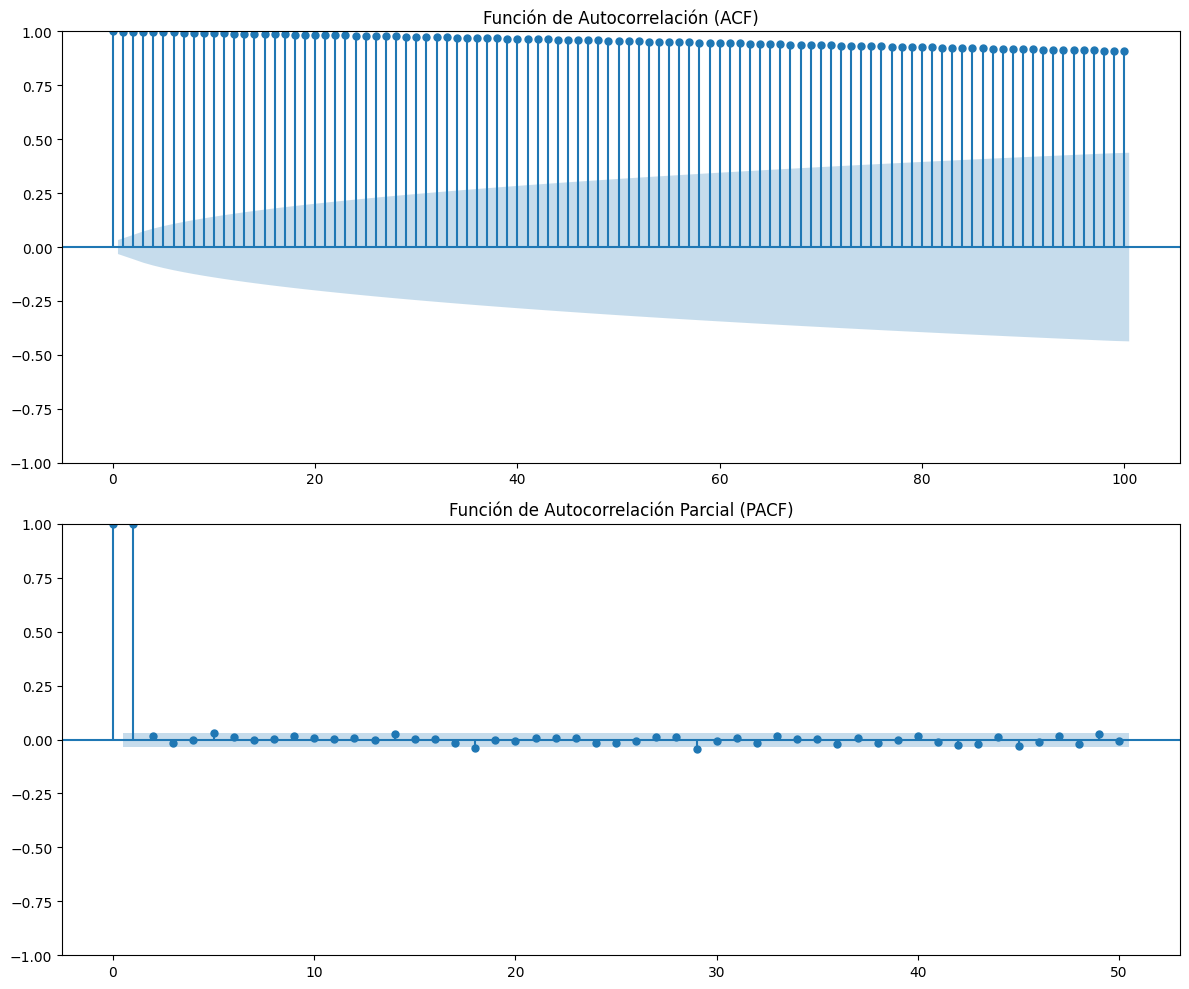

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.subplot(211)
plot_acf(df_completo['Close'], ax=plt.gca(), lags=100)
plt.title('Función de Autocorrelación (ACF)')

plt.subplot(212)
plot_pacf(df_completo['Close'], ax=plt.gca(), lags=50)
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.tight_layout()
plt.show()

### Análisis del Código ARIMA

1. **Hiperparámetros a Optimizar**:
   - **`p`**: Número de términos autorregresivos (AR). Se exploran los valores en el rango de 1 a 3. Dado el grafico **PACF** 
   - **`d`**: Número de diferencias estacionales. Se exploran los valores en el rango de 0 a 2.
   - **`q`**: Número de términos de media móvil (MA). Se exploran los valores en el rango de 0 a 9.
   - La optimización se realiza mediante una búsqueda en cuadrícula (Grid Search) que evalúa todas las combinaciones posibles de estos parámetros y selecciona aquella que minimiza el criterio de información Akaike (AIC).

2. **Parámetros Asumidos**:
   - **`train_ratio`**: 70% de los datos se utilizan para entrenamiento.
   - **`val_ratio`**: 15% de los datos se utilizan para validación.
   - **`test_ratio`**: 15% de los datos se utilizan para pruebas.
   - La función `train_and_predict` ajusta el modelo ARIMA con los parámetros `(p, d, q)` y realiza una predicción para el siguiente paso en la serie temporal.

3. **Precisión del Modelo**:
   - La precisión del modelo se evalúa utilizando el **Error Cuadrático Medio (MSE)** calculado sobre los residuales de la predicción rolling.
   - Se realiza una predicción rolling, ajustando el modelo ARIMA para cada punto en el conjunto de prueba y calculando los residuales.

4. **Manejo de Resultados**:
   - **Optimización**: Se encuentra el mejor conjunto de parámetros `(p, d, q)` basado en el AIC y se muestra en un DataFrame.
   - **Predicción Rolling**: Se realiza una predicción rolling en el conjunto de prueba, calculando y visualizando los residuales.
   - **Gráficos**: Se generan gráficos para los residuales, su autocorrelación y su tendencia usando LOESS, así como un gráfico comparativo de las predicciones del modelo ARIMA frente a los datos reales.
   - **Resultados del MSE**: Se muestra el MSE del modelo ARIMA en los datos de prueba en un DataFrame.



In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
from tqdm import tqdm
import statsmodels.api as sm
from scipy import stats
import itertools
import time
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings('ignore')

# Función para entrenar y predecir usando ARIMA
def train_and_predict(df, p, d, q):
    model = ARIMA(df['Close'], order=(p, d, q))
    fitted_model = model.fit()
    return fitted_model.forecast(steps=1), fitted_model

# Función para plotear residuos y estadísticas
def plot_residuals_and_stats(date, residuals, title, fig, axs):
    plt.suptitle(f'Residual Analysis for ARIMA model: {title}')
    
    # Aseguramos que residuals sea un array de NumPy
    residuals = np.array(residuals)
    
    # Residuals plot
    axs[0, 0].plot(date, residuals)
    axs[0, 0].set_title('Residuals')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].axhline(0, color='red', linestyle='--')
    
    # ACF plot
    plot_acf(residuals, lags=24, ax=axs[0, 1])
    axs[0, 1].set_title('ACF of Residuals')
    
    # PACF plot
    plot_pacf(residuals, lags=24, ax=axs[1, 0])
    axs[1, 0].set_title('PACF of Residuals')
    
    # Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axs[1, 1])
    axs[1, 1].set_title('Q-Q Plot')
    
    # Ljung-Box test
    lb_lag = min(24, len(residuals)//4)
    lb_test = acorr_ljungbox(residuals, lags=[lb_lag], return_df=True)
    lb_statistic = lb_test['lb_stat'].values[0]
    lb_pvalue = lb_test['lb_pvalue'].values[0]
    lb_result = f"Ljung-Box test (lag={lb_lag}):\nStatistic = {lb_statistic:.4f}, p-value = {lb_pvalue:.4f}"
    
    if lb_pvalue < 0.05:
        lb_interpretation = "Hay evidencia de autocorrelación en los residuos."
    else:
        lb_interpretation = "No hay evidencia significativa de autocorrelación en los residuos."
    
    # Jarque-Bera test
    jb_statistic, jb_pvalue = stats.jarque_bera(residuals)
    jb_result = f"Jarque-Bera test:\nStatistic = {jb_statistic:.4f}, p-value = {jb_pvalue:.4f}"
    
    if jb_pvalue < 0.05:
        jb_interpretation = "Los residuos no siguen una distribución normal."
    else:
        jb_interpretation = "No hay evidencia significativa de que los residuos no sigan una distribución normal."
    
    # Add test results and interpretations as text
    fig.text(0.1, 0.01, lb_result + '\n' + lb_interpretation + '\n\n' + jb_result + '\n' + jb_interpretation, 
             ha='left', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # CUSUM plot
    cum = np.cumsum(residuals) / np.std(residuals)
    N = len(residuals)
    Af = 0.948
    LS = Af * np.sqrt(N) + 2 * Af * np.arange(1, N+1) / np.sqrt(N)
    LI = -LS
    
    fig_cusum, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    ax1.plot(cum, label='CUSUM')
    ax1.plot(LS, 'r--', label='Upper Bound')
    ax1.plot(LI, 'r--', label='Lower Bound')
    ax1.set_title('CUSUM')
    ax1.legend()
    
    # CUSUMSQ plot
    cumq = np.cumsum(residuals**2) / np.sum(residuals**2)
    co = 0.14422
    LQS = co + np.arange(1, N+1) / N
    LQI = -co + np.arange(1, N+1) / N
    
    ax2.plot(cumq, label='CUSUMSQ')
    ax2.plot(LQS, 'r--', label='Upper Bound')
    ax2.plot(LQI, 'r--', label='Lower Bound')
    ax2.set_title('CUSUMSQ')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Cargar los datos


# Segmentación de los datos
print("Preparando los datos...")
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
n = len(df_completo)
train_size = int(n * train_ratio)
val_size = int(n * val_ratio)

train_data = df_completo.iloc[:train_size]
val_data = df_completo.iloc[train_size:train_size + val_size]
test_data = df_completo.iloc[train_size + val_size:]

# Grid Search para optimización de parámetros
print("Iniciando Grid Search para optimización de parámetros...")
start_time = time.time()

# Definir el rango de parámetros
p = [1]  # Fijado a 1
d = range(0, 3)  # 0, 1, 2
q = range(0, 10)  # 0, 1, 2, 3, ..., 9

# Crear todas las combinaciones posibles
pdq = list(itertools.product(p, d, q))

# Realizar Grid Search
best_aic = float("inf")
best_params = None
best_model = None

for param in tqdm(pdq, desc="Optimizing ARIMA model"):
    try:
        model = ARIMA(train_data['Close'], order=param)
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_params = param
            best_model = results
    except:
        continue

best_p, best_d, best_q = best_params

optimization_time = time.time() - start_time
print(f"Grid Search completado en {optimization_time:.2f} segundos.")

best_params_df = pd.DataFrame({
    "Parametro": ["p", "d", "q"],
    "Valor": [best_p, best_d, best_q]
})

print("Mejores parámetros encontrados:")
display(best_params_df)

# Calcular los residuales intramuestra (train_residuals)
print("Calculando residuales intramuestra...")
train_predictions = best_model.fittedvalues
train_residuals = train_data['Close'] - train_predictions

# Calcular los residuales de prueba (test_residuals)
print("Calculando residuales de prueba...")
test_residuals = []
for i in tqdm(range(len(test_data)), desc="Rolling ARIMA model"):
    expanded_train_data = pd.concat([train_data, test_data.iloc[:i]])
    pred, _ = train_and_predict(expanded_train_data, best_p, best_d, best_q)
    test_residuals.append(test_data['Close'].iloc[i] - pred.iloc[0])

Preparando los datos...
Iniciando Grid Search para optimización de parámetros...


Optimizing ARIMA model: 100%|██████████| 30/30 [01:07<00:00,  2.27s/it]

Grid Search completado en 68.00 segundos.
Mejores parámetros encontrados:


,Parametro,Valor
0,p,1
1,d,1
2,q,0


Calculando residuales intramuestra...
Calculando residuales de prueba...


Rolling ARIMA model: 100%|██████████| 549/549 [01:32<00:00,  5.94it/s]


Analicemos estos resultados para determinar si tienen sentido:

1. p = 1: Esto significa que el orden autoregresivo es de orden 1,AR(1).
2. d = 1: Indica que se aplicó una diferenciación de primer orden.
3. q = 0: Significa que no hay componente de media móvil (MA) en el modelo.

$$
(1- \Phi B)(1 - B)X_t =  Z_t 
$$

Con la prubea AD Fuller al tener raiz unitaria se espera que tenga una raiz unitaria

**Desempeño del Modelo**:
  - **MSE**: 0.273762

In [11]:
# Calcular los valores predichos para los datos de prueba
test_predictions = test_data['Close'] - np.array(test_residuals)

# Usar la función plot_ para visualizar la comparación
plot_("Comparación de Valores Reales y Predichos",
      (test_data.index, test_data['Close'], "Valores Reales"),
      (test_data.index, test_predictions, "Valores Predichos"))

Generando gráficos para residuales intramuestra...


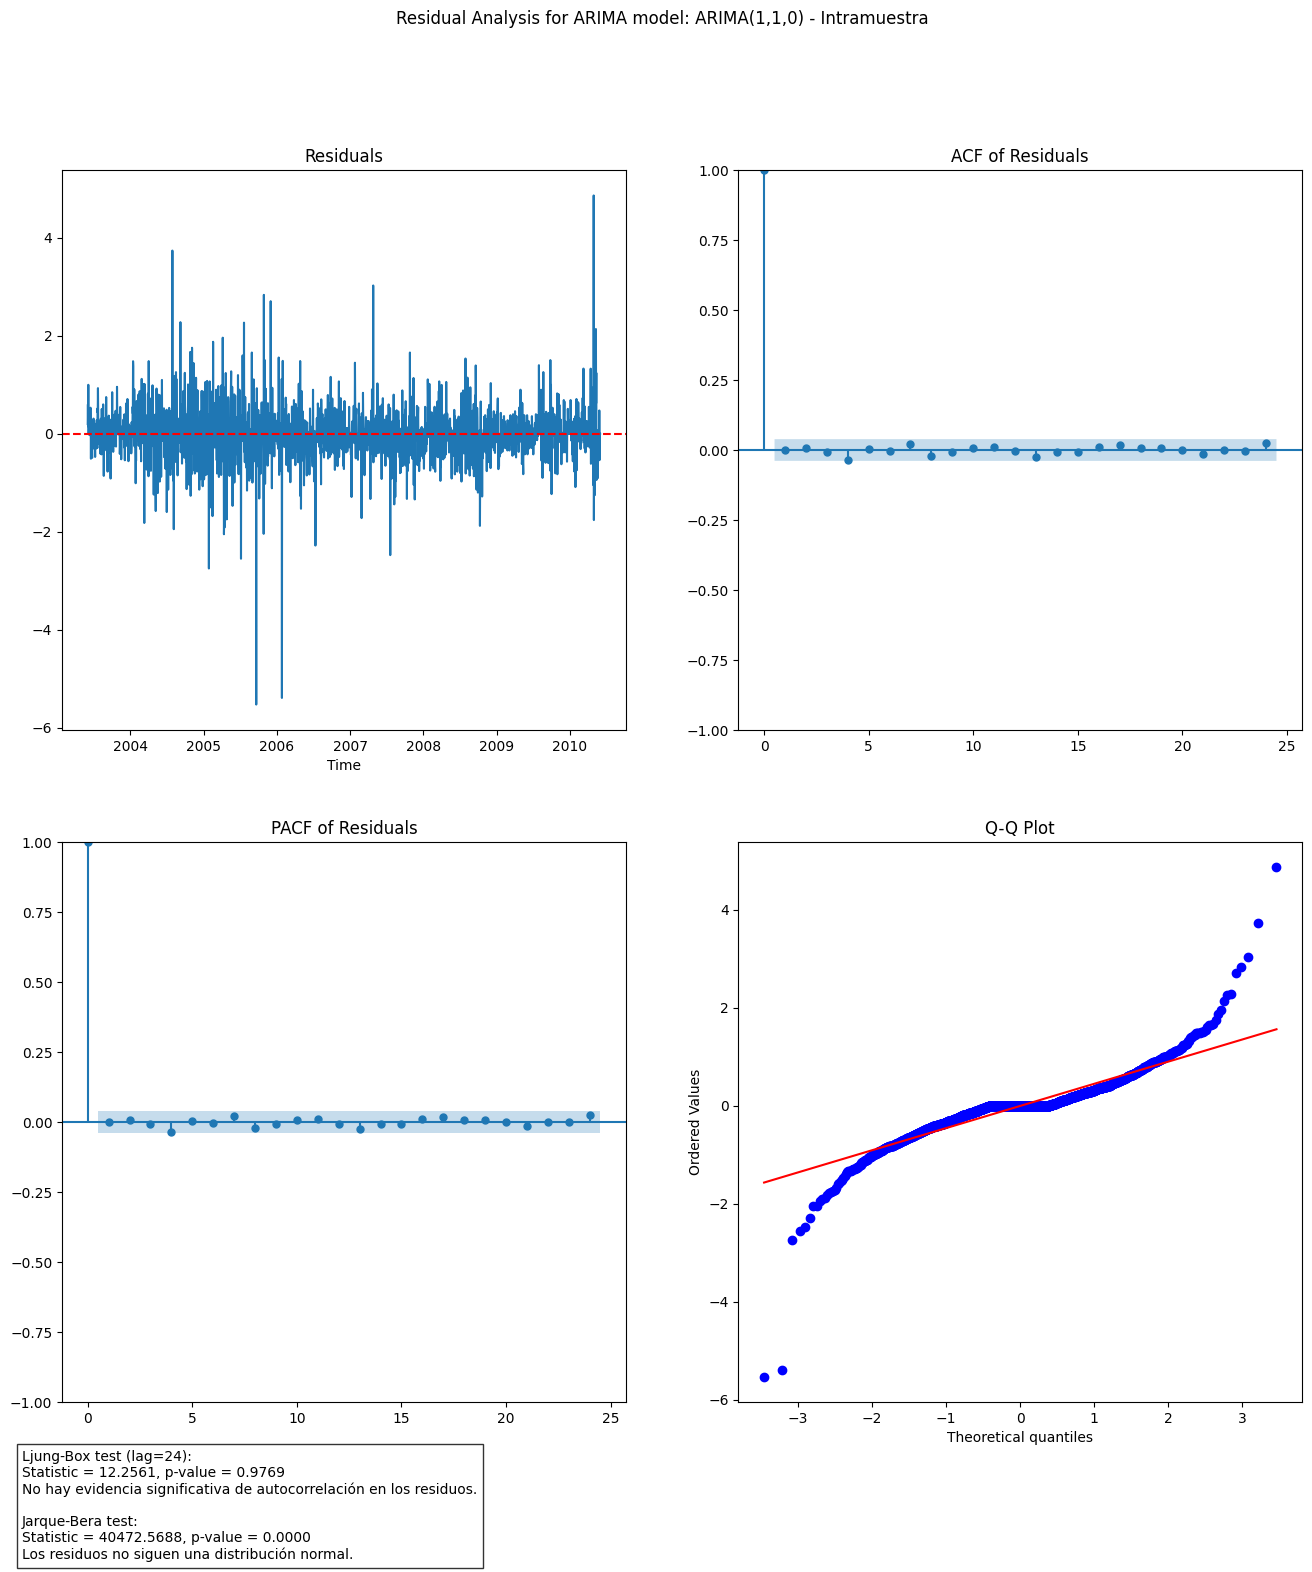

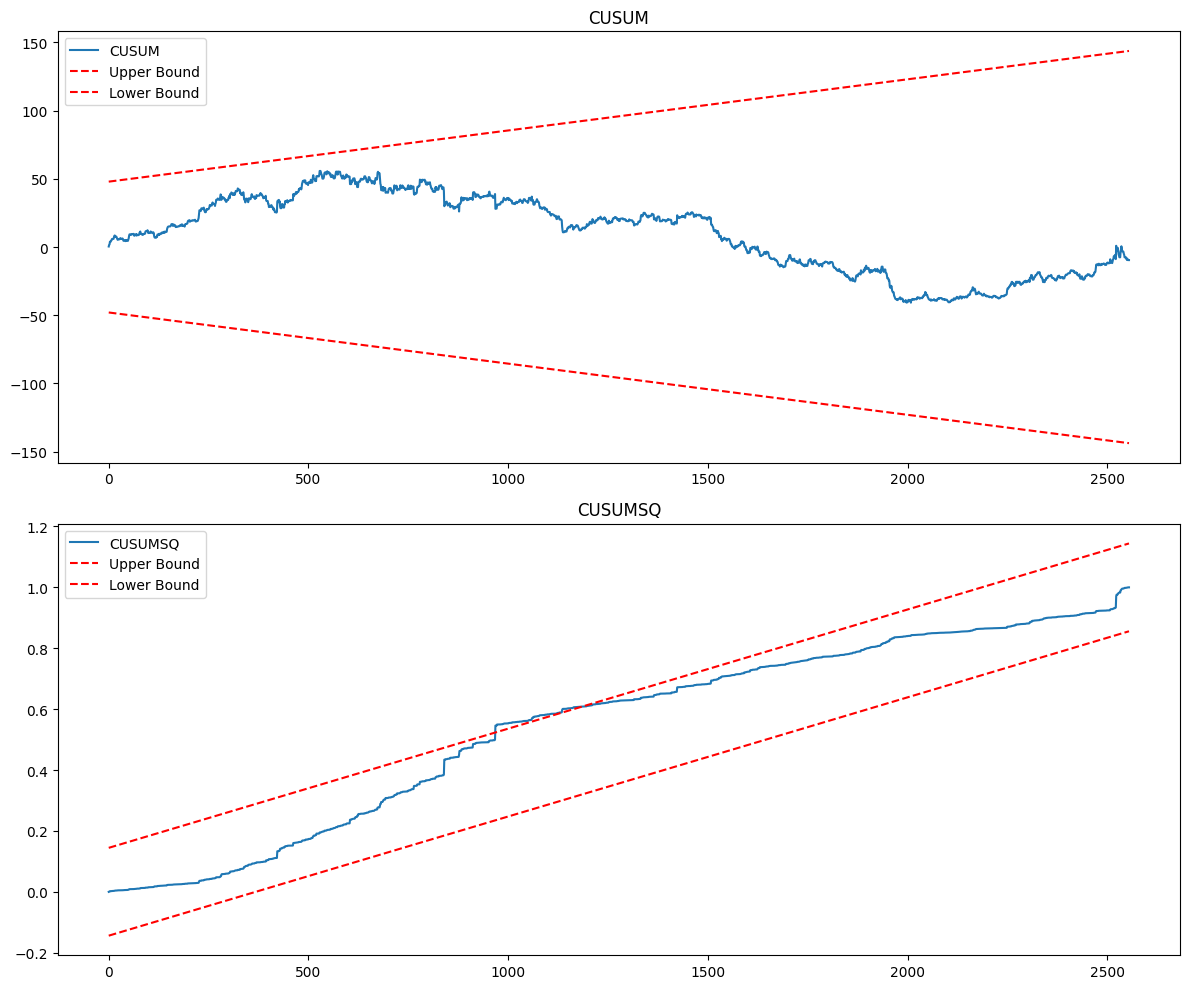

Generando gráficos para residuales de prueba...


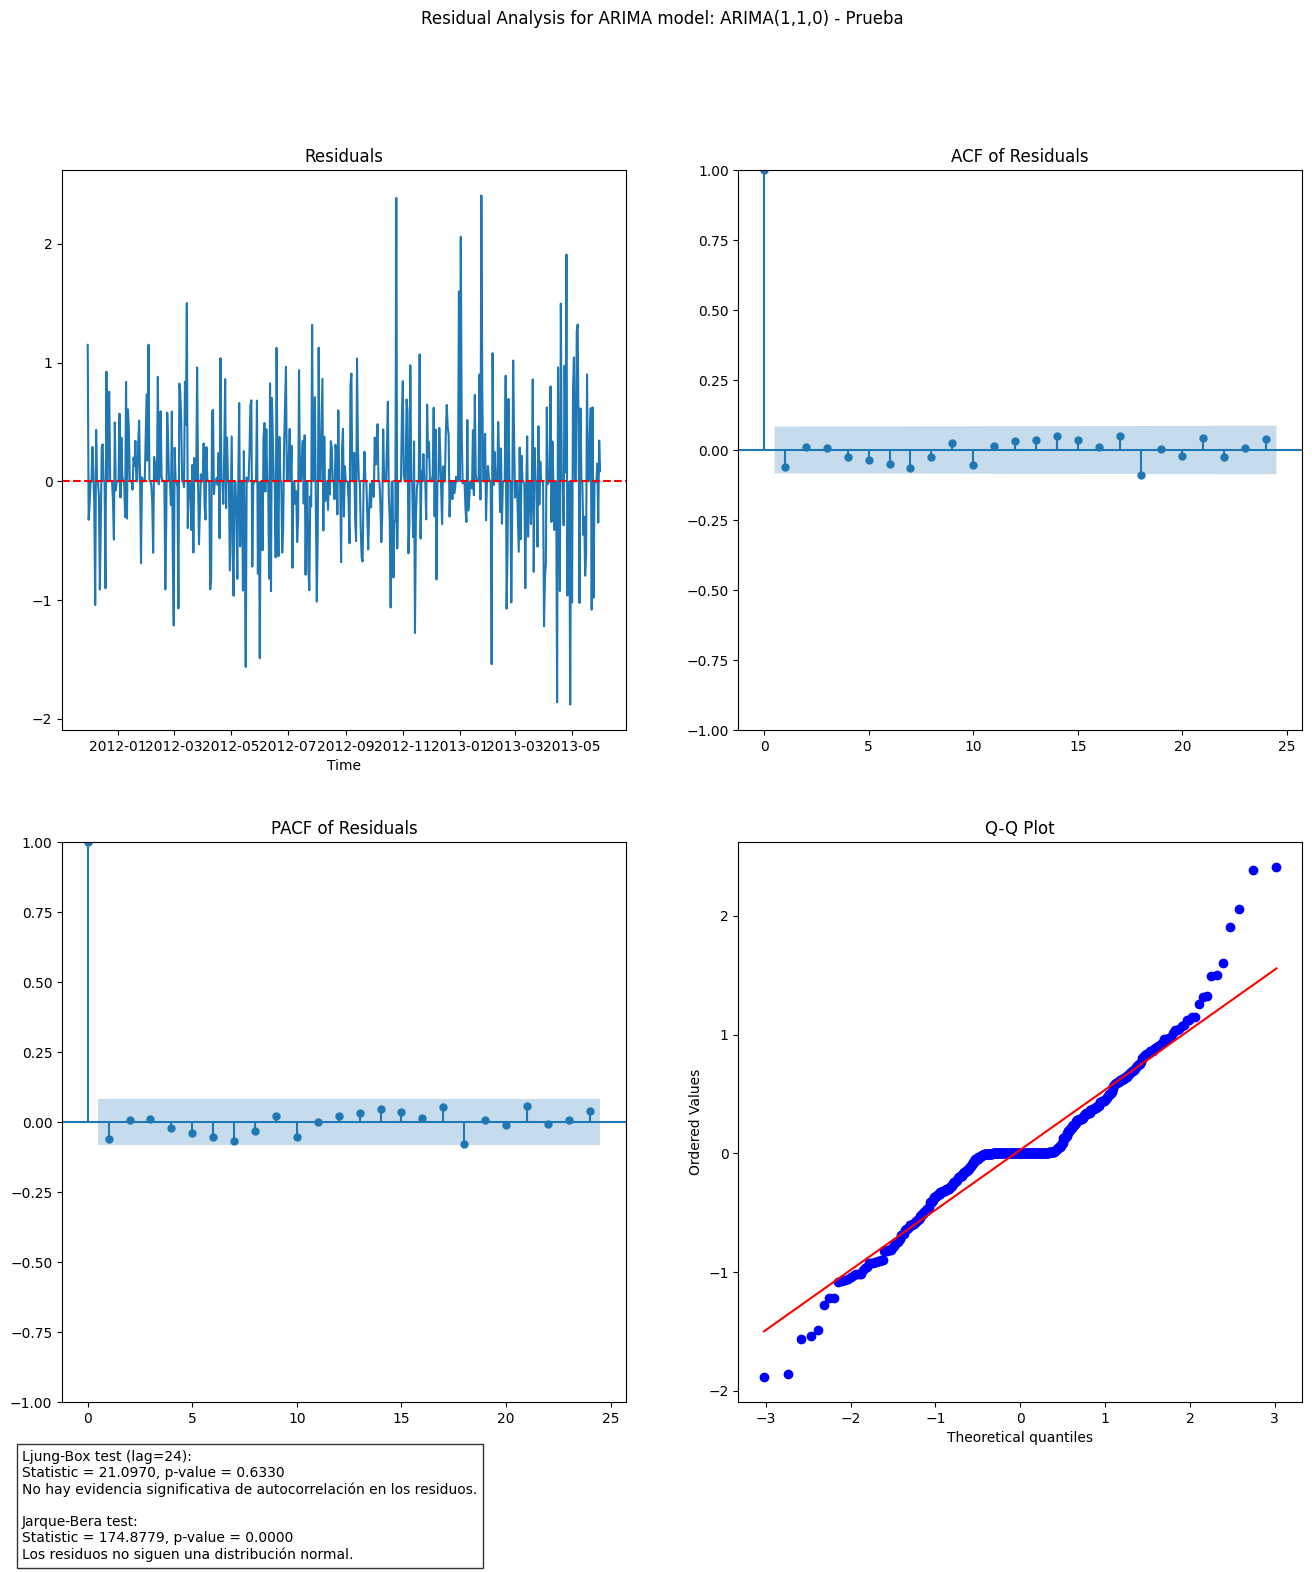

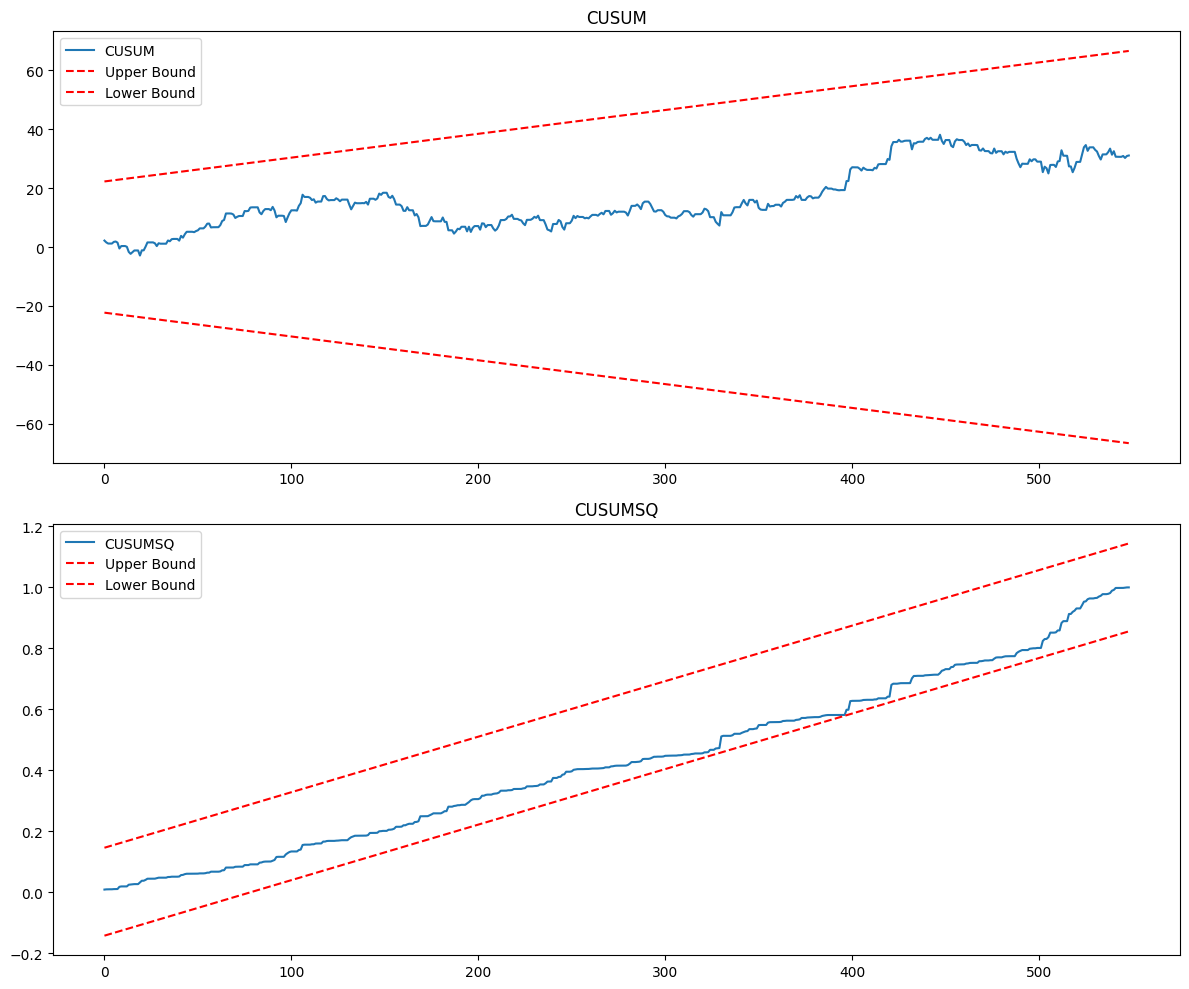

Resultados del MSE:
          Model       MSE
0  ARIMA(1,1,0)  0.273762


In [12]:


# Plotting
print("Generando gráficos para residuales intramuestra...")
fig_train, axs_train = plt.subplots(2, 2, figsize=(16, 16))
plot_residuals_and_stats(train_data.index[1:], train_residuals[1:], f"ARIMA({best_p},{best_d},{best_q}) - Intramuestra", fig_train, axs_train)

print("Generando gráficos para residuales de prueba...")
fig_test, axs_test = plt.subplots(2, 2, figsize=(16, 16))
plot_residuals_and_stats(test_data.index, test_residuals, f"ARIMA({best_p},{best_d},{best_q}) - Prueba", fig_test, axs_test)

# Calcula y muestra el MSE
mse = mean_squared_error(test_data['Close'], test_data['Close'] - np.array(test_residuals))
mse_results_ARIMA = pd.DataFrame({
    "Model": [f"ARIMA({best_p},{best_d},{best_q})"],
    "MSE": [mse]
})

print("Resultados del MSE:")
print(mse_results_ARIMA)

plt.show()

Se observa discrepancias positiva en el 2012-10 y negativa en  2013-05, aunque explica claramente la tendencia, y la autocrrelación de los datos, aunque se observa un lag 18 significativo.